# Advanced Spatial Analysis: Spatial Accessibility

## Overview
In this lecture, we will investigate a method to measure spatial accessibility. The method is called the two-step floating catchment area (2SFCA). The method has been spotlighted as it includes the interactions among supply, demand, and mobility, and it is straightforward, making this method relatively easy to replicate and reproduce. 
The method consists of two steps, as you can tell from its name. The first step is to calculate the supply-to-demand ratio of each infrastructure (e.g., hospitals). The second step is to sum the ratio from the locations of demand. In both steps, the method considers the interaction between the supply and demand that is only accessible within a particular threshold travel cost (e.g., 30 minutes or 10 km).  

### First step:

$$\huge R_j = \frac{S_j}{\sum_{k\in {\left\{d_{kj} \le d_0 \right\}}}^{}P_k}$$
where<br>
$R_j$: the supply-to-demand ratio of location $j$. <br>
$S_j$: the degree of supply (e.g., number of doctors) at location $j$. <br>
$P_k$: the degree of demand (e.g., population) at location $k$. <br>
$d_{kj}$: the travel cost between locations $k$ and $j$. <br>
$d_0$: the threshold travel cost of the analysis. 

### Second step:
$$\huge A_i = \sum_{j\in {\left\{d_{ij} \le d_0 \right\}}} R_j$$
where<br>
$A_i$: the accessibility measures at location $i$. <br>
$R_j$: the supply-to-demand ratio of location $j$. <br>

![](./data/fig1.jpg)


Source: <br>
* Luo, W., & Wang, F. (2003). Measures of spatial accessibility to health care in a GIS environment: Synthesis and a case study in the Chicago region. *Environment and Planning B: Planning and Design*, 30(6), 865–884. <br>
* Data is obtained from https://github.com/cybergis/COVID_19Accessibility

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import time
from tqdm import tqdm, trange
from shapely.geometry import Point, MultiPoint
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")

## Import Data

In [2]:
# Supply: hospitals in the city of Chicago
hospitals = gpd.read_file('./data/Chicago_Hospital_Info.shp')
hospitals.head(1)

,Hospital,City,ZIP_Code,X,Y,Total_Bed,geometry
0,Methodist Hospital of Chicago,Chicago,60640,-87.671079,41.9728,145,POINT (-87.67108 41.97280)


In [3]:
# Demand: population per census tract
tracts = gpd.read_file('./data/Chicago_Tract.shp')
tracts.head(1)

,GEOID,OverFifty,TotalPop,geometry
0,17031010400,1103,5153,"POLYGON ((-87.66125 42.01288, -87.66125 42.012..."


<AxesSubplot:>

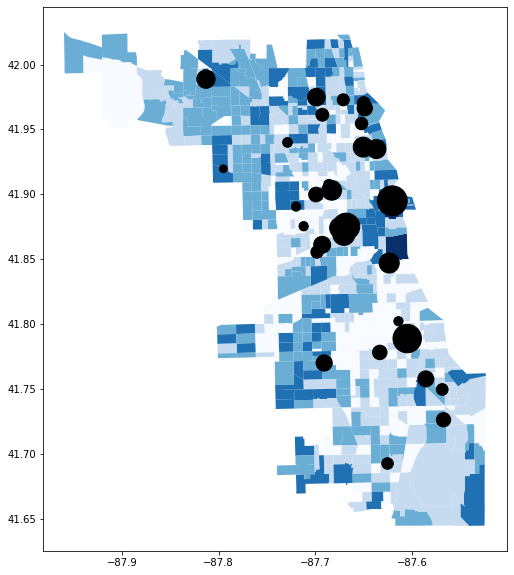

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))

tracts.plot('TotalPop', ax=ax, scheme='FisherJenks', cmap='Blues')
hospitals.plot(markersize='Total_Bed', ax=ax, color='black')

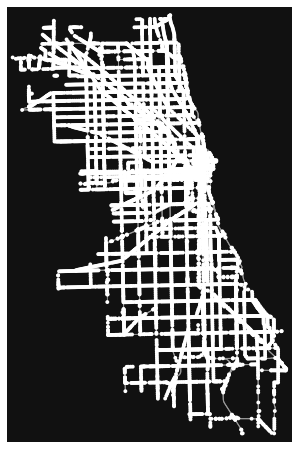

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [5]:
# Mobility: Chicago Road Network
G = ox.io.load_graphml('./data/chicago_road.graphml')
ox.plot_graph(G)

In [6]:
'''
## This cell demonstrates how you can make the identical network dataset from OSMnx. 

# Obtain OSM Network in the city of Chicago
G = ox.graph_from_place('Chicago, IL, USA', network_type='drive', simplify=True)

# Remove edges
for u, v, data in G.copy().edges(data=True):
    if data['highway'] not in ['motorway', 'motorway_link', 
                               'trunk', 'trunk_link',
                               'primary', 'primary_link', 
                               'secondary', 'secondary_link']:
        G.remove_edge(u, v)
        
# Remove nodes
G.remove_nodes_from(list(nx.isolates(G)))

# Save OSM Network to Graphml
ox.io.save_graphml(G, './data/chicago_road.graphml')

'''

"\n## This cell demonstrates how you can make the identical network dataset from OSMnx. \n\n# Obtain OSM Network in the city of Chicago\nG = ox.graph_from_place('Chicago, IL, USA', network_type='drive', simplify=True)\n\n# Remove edges\nfor u, v, data in G.copy().edges(data=True):\n    if data['highway'] not in ['motorway', 'motorway_link', \n                               'trunk', 'trunk_link',\n                               'primary', 'primary_link', \n                               'secondary', 'secondary_link']:\n        G.remove_edge(u, v)\n        \n# Remove nodes\nG.remove_nodes_from(list(nx.isolates(G)))\n\n# Save OSM Network to Graphml\nox.io.save_graphml(G, './data/chicago_road.graphml')\n\n"

## Data Preprocessing

In [7]:
# This function helps you to find the nearest OSM node from a given GeoDataFrame
# If geom type is point, it will take it without modification, but 
# IF geom type is polygon or multipolygon, it will take its centroid to calculate the nearest element. 

def find_nearest_osm(network, gdf):
    for idx, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        if row.geometry.geom_type == 'Point':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                                    X=row.geometry.x, 
                                                    Y=row.geometry.y
                                                   )
        elif row.geometry.geom_type == 'Polygon' or row.geometry.geom_type == 'MultiPolygon':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                        X=row.geometry.centroid.x, 
                                        Y=row.geometry.centroid.y
                                       )
        else:
            print(row.geometry.geom_type)
            continue

        gdf.at[idx, 'nearest_osm'] = nearest_osm

    return gdf

supply = find_nearest_osm(G, hospitals)
demand = find_nearest_osm(G, tracts)

100%|████████████████████████████████████████████████████████████████████| 878/878 [00:42<00:00, 20.56it/s]


In [8]:
# Extract the nodes and edges of the network dataset for the future analysis. 
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True)
nodes.head(1)

,y,x,street_count,ref,highway,geometry
osmid,,,,,,
701660,41.983951,-87.849198,3,NaN,NaN,POINT (-87.84920 41.98395)


## Procedural demonstration

The following procedure demonstrates how to make a catchment area from a given location. 
1. Calculate accessible nodes in the network dataset from a given location with `nx.single_source_dijkstra_path_length()`. The function returns a dictionary (keys: OSMID, values: distance from a given location).  
2. Extract the locations (or coordinates) of accessible nodes based on the OSMID. 
3. Create a convex hull with the locations of the nodes. 

In [9]:
# Threshold travel time
dist = 10000

# Calculate the number of census tract that is accessible to each hospital
# This returns the dictionary that has OSM node as its key and the distance as value.
temp_nodes = nx.single_source_dijkstra_path_length(G, supply.loc[0, 'nearest_osm'], dist, weight='length')
temp_nodes

{257156478.0: 0,
 2746289365: 175.263,
 286900099: 506.048,
 2447758386: 516.64,
 257157069: 633.781,
 250278855: 669.894,
 257173249: 708.236,
 257157208: 763.8219999999999,
 257168958: 764.2,
 1472093709: 797.241,
 4069241715: 847.3779999999999,
 1299650251: 875.915,
 257172685: 893.5239999999999,
 1370022135: 909.31,
 257110950: 910.502,
 262158757: 939.8549999999999,
 1370022151: 942.194,
 2316599984: 1001.3800000000001,
 2447758391: 1022.79,
 1370022131: 1033.302,
 262158813: 1062.096,
 1370022147: 1063.9029999999998,
 257154258: 1077.1090000000002,
 257110949: 1078.545,
 2869202036: 1113.3129999999999,
 4069241712: 1124.432,
 1370022153: 1166.8389999999997,
 257156476: 1171.2210000000002,
 262158977: 1185.241,
 257154379: 1202.9239999999998,
 4069241716: 1224.772,
 257156271: 1280.2720000000002,
 257168664: 1283.8020000000001,
 257157895: 1308.804,
 26794602: 1316.2019999999998,
 3921165858: 1316.6939999999997,
 2447758377: 1327.7299999999998,
 4069241713: 1328.193,
 291140811: 1

In [10]:
# Slice the `nodes` GeoDataFrame to collect the location of the nodes based on their OSMID. 
access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']
access_nodes

osmid
25779161      POINT (-87.66092 41.90090)
25779173      POINT (-87.65711 41.89502)
25779174      POINT (-87.65598 41.89430)
26098166      POINT (-87.63053 41.92416)
26099529      POINT (-87.63362 41.92575)
                         ...            
9325600736    POINT (-87.65370 41.98369)
9391285688    POINT (-87.66782 41.91620)
9408505613    POINT (-87.63120 41.89483)
9408702955    POINT (-87.70680 41.93913)
9408702959    POINT (-87.70685 41.93936)
Name: geometry, Length: 2839, dtype: geometry

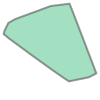

In [11]:
access_nodes.unary_union  # Union every nodes
access_nodes.unary_union.convex_hull # Create convex hull from the unioned nodes

<AxesSubplot:>

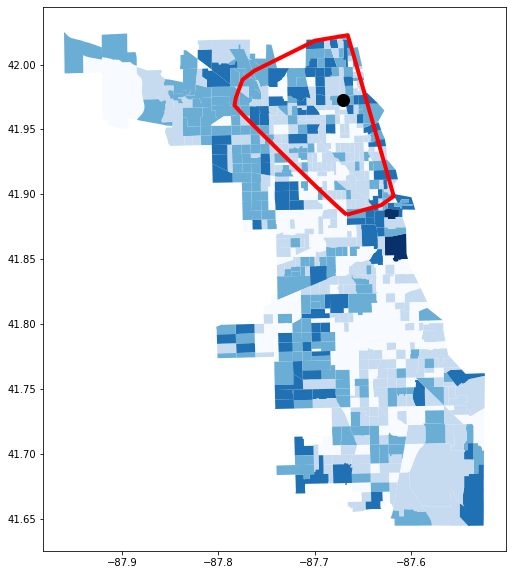

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

tracts.plot('TotalPop', ax=ax, scheme='FisherJenks', cmap='Blues')

access_nodes = gpd.GeoSeries(access_nodes.unary_union.convex_hull, crs="EPSG:4326")
access_nodes.boundary.plot(ax=ax, color='red', linewidth=4)

supply_0 = supply.loc[supply.index==0]
supply_0.plot(markersize='Total_Bed', ax=ax, color='black')

In [13]:
# In summary, the following is the necessary code to create a catchment area from a given location. 
dist = 10000

# 1. Calculate accessible nodes in the network dataset from a given location 
temp_nodes = nx.single_source_dijkstra_path_length(G, supply.loc[0, 'nearest_osm'], dist, weight='length')

# 2. Extract the locations (or coordinates) of accessible nodes based on the OSMID.
access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']

# 3. Create a convex hull with the locations of the nodes.
access_nodes = gpd.GeoSeries(access_nodes.unary_union.convex_hull, crs="EPSG:4326")

# Result. 
demand.loc[demand['geometry'].centroid.within(access_nodes[0])]

,GEOID,OverFifty,TotalPop,geometry,nearest_osm
1,17031010600,1469,6271,"POLYGON ((-87.67059 42.00537, -87.67046 42.005...",2.611651e+08
2,17031030200,2018,5444,"POLYGON ((-87.67062 41.99808, -87.67045 41.998...",2.872157e+08
3,17031030300,1097,3464,"POLYGON ((-87.67501 41.99799, -87.67473 41.998...",2.872142e+08
4,17031030400,860,2582,"POLYGON ((-87.67471 41.99076, -87.67440 41.990...",2.621622e+08
5,17031030900,1039,3061,"POLYGON ((-87.67461 41.98336, -87.67447 41.983...",2.571700e+08
...,...,...,...,...,...
795,17031020302,1666,5348,"POLYGON ((-87.69983 42.00487, -87.69983 42.005...",2.611707e+08
823,17031151002,1276,4770,"POLYGON ((-87.75201 41.94606, -87.75154 41.946...",3.177498e+08
825,17031150800,1617,4967,"POLYGON ((-87.75715 41.95330, -87.75690 41.953...",3.163259e+08
826,17031161100,660,2043,"POLYGON ((-87.74268 41.95347, -87.74259 41.953...",6.412881e+09


---
### *Exercise*

You may have understood the concept of 2SFCA method and how to calculate the catchment area. Here, we want to calculate the number of demand locations (i.e., census tract) accessible from each supply location (i.e., hospitals). This will be the preliminary supply-to-demand ratio of each hospital, assuming that there are **no weights** on the supply and demand. Then, return the result as `count` column of `supply_` GeoDataFrame (which is the copy of `supply` GeoDataFrame). <br>

The result should look like the below. 
![](./data/fig2.jpg)


```python
supply_ = supply.copy(deep=True)
supply_['count'] = 0

for i in range(supply.shape[0]):
    ### Your code here

    

    # Enter the number of demand location into the `count` column. 
    supply_.at[i, 'count'] = demand_count

```
Once we know the preliminary supply-to-demand ratio, we can incorporate the weigths of hospitals and census tracts, based on the bed count and population, respectively. 

---

In [14]:
# Your code here

supply_ = supply.copy(deep=True)
supply_['count'] = 0

for i in range(supply.shape[0]):
    # Your code here
    temp_nodes = nx.single_source_dijkstra_path_length(G, supply.loc[i, 'nearest_osm'], dist, weight='length')
    access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']
    access_nodes = gpd.GeoSeries(access_nodes.unary_union.convex_hull, crs="EPSG:4326")
    demand_count = demand.loc[demand['geometry'].centroid.within(access_nodes[0])].shape[0]
    
    supply_.at[i, 'count'] = demand_count
    
supply_.head(5)

,Hospital,City,ZIP_Code,X,Y,Total_Bed,geometry,nearest_osm,count
0,Methodist Hospital of Chicago,Chicago,60640,-87.671079,41.972800,145,POINT (-87.67108 41.97280),257156478.0,252
1,Holy Cross Hospital,Chicago,60629,-87.690841,41.770001,264,POINT (-87.69084 41.77000),261271679.0,210
2,Jackson Park Hospital & Medical Center,Chicago,60649,-87.585693,41.757760,256,POINT (-87.58569 41.75776),266485371.0,181
3,Mercy Hospital & Medical Center,Chicago,60616,-87.623542,41.847044,402,POINT (-87.62354 41.84704),349820645.0,259
4,Mount Sinai Hospital Medical Center,Chicago,60608,-87.692865,41.861120,288,POINT (-87.69286 41.86112),261132835.0,330


In [15]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""
assert supply_.loc[6, 'count'] == 360
assert supply_.loc[24, 'count'] == 280

print('Success!')

Success!


## Measuring Accessibility to Hospitals in Chicago

With the skeleton we just created in the previous cell, we now want to incorporate the weights of supply and demand based on the bed count and population, respectively.

### Step1 of 2SFCA method: calculate the supply-to-demand ratio of each infrastructure (e.g., hospitals)

$$\large R_j = \frac{S_j}{\sum_{k\in {\left\{d_{kj} \le d_0 \right\}}}^{}P_k}$$
where<br>
$R_j$: the supply-to-demand ratio of location $j$. <br>
$S_j$: the degree of supply (e.g., number of doctors) at location $j$. <br>
$P_k$: the degree of demand (e.g., population) at location $k$. <br>
$d_{kj}$: the travel cost between locations $k$ and $j$. <br>
$d_0$: the threshold travel cost of the analysis. 


In [16]:
supply_ = supply.copy(deep=True)
supply_['ratio'] = 0

for i in range(supply.shape[0]):
    
    # Create a catchment area from a given location
    temp_nodes = nx.single_source_dijkstra_path_length(G, supply.loc[i, 'nearest_osm'], dist, weight='length')
    access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']
    access_nodes = gpd.GeoSeries(access_nodes.unary_union.convex_hull, crs="EPSG:4326")
    
    # Calculate the population within the catchment area
    temp_demand = demand.loc[demand['geometry'].centroid.within(access_nodes[0]), 'TotalPop'].sum()
    
    # Calculate the number of hospital beds in each hospital
    temp_supply = supply.loc[i, 'Total_Bed']
    
    # Calculate the number of hospital beds available for 100,000 people 
    supply_.at[i, 'ratio'] = temp_supply / temp_demand * 100000
    
supply_.head(5)

,Hospital,City,ZIP_Code,X,Y,Total_Bed,geometry,nearest_osm,ratio
0,Methodist Hospital of Chicago,Chicago,60640,-87.671079,41.972800,145,POINT (-87.67108 41.97280),257156478.0,15.564921
1,Holy Cross Hospital,Chicago,60629,-87.690841,41.770001,264,POINT (-87.69084 41.77000),261271679.0,39.626847
2,Jackson Park Hospital & Medical Center,Chicago,60649,-87.585693,41.757760,256,POINT (-87.58569 41.75776),266485371.0,56.786295
3,Mercy Hospital & Medical Center,Chicago,60616,-87.623542,41.847044,402,POINT (-87.62354 41.84704),349820645.0,53.404681
4,Mount Sinai Hospital Medical Center,Chicago,60608,-87.692865,41.861120,288,POINT (-87.69286 41.86112),261132835.0,26.549945


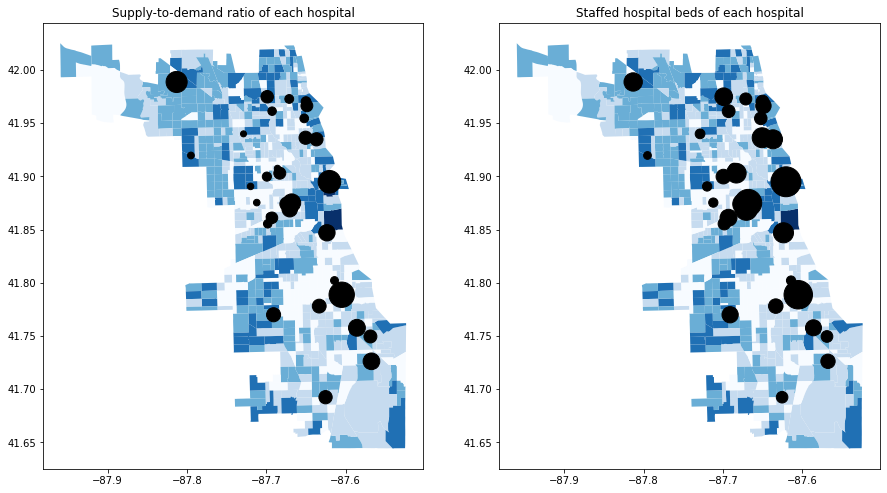

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

tracts.plot('TotalPop', ax=axes[0], scheme='FisherJenks', cmap='Blues')
supply_.plot(markersize=supply_['ratio'] * 5, ax=axes[0], color='black')
axes[0].set_title('Supply-to-demand ratio of each hospital')

tracts.plot('TotalPop', ax=axes[1], scheme='FisherJenks', cmap='Blues')
hospitals.plot(markersize='Total_Bed', ax=axes[1], color='black')
axes[1].set_title('Staffed hospital beds of each hospital')

plt.show()

### Step2 of 2SFCA method: sum the ratio from the locations of demand.

$$\large A_i = \sum_{j\in {\left\{d_{ij} \le d_0 \right\}}} R_j$$
where<br>
$A_i$: the accessibility measures at location $i$. <br>
$R_j$: the supply-to-demand ratio of location $j$. <br>
$d_{kj}$: the travel cost between locations $k$ and $j$. <br>
$d_0$: the threshold travel cost of the analysis. 


<AxesSubplot:>

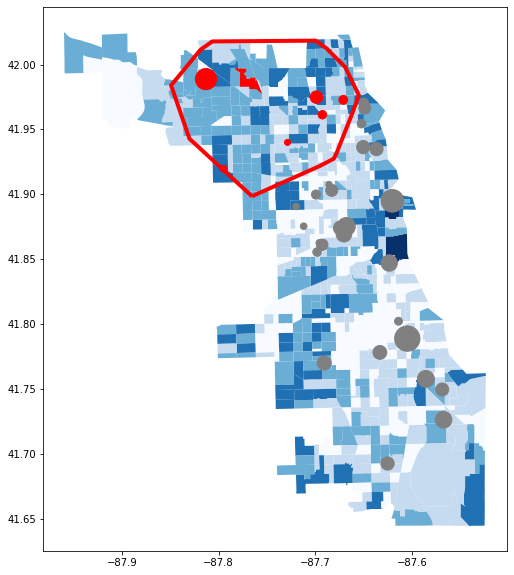

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))

tracts.plot('TotalPop', ax=ax, scheme='FisherJenks', cmap='Blues')
tracts.loc[tracts.index==105].plot(ax=ax, color='red')

# Plot catchment area
temp_nodes = nx.single_source_dijkstra_path_length(G, demand.loc[105, 'nearest_osm'], dist, weight='length')
access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']
access_nodes = gpd.GeoSeries(access_nodes.unary_union.convex_hull, crs="EPSG:4326")
access_nodes.boundary.plot(ax=ax, color='red', linewidth=4)

# Calculate accessible hospital from a census tract
access_supply_ = supply_.loc[supply_['geometry'].centroid.within(access_nodes[0])]
non_access_supply_ = supply_.loc[~supply_['geometry'].centroid.within(access_nodes[0])]

access_supply_.plot(ax=ax, markersize=access_supply_['ratio']*5, color='red')
non_access_supply_.plot(ax=ax, markersize=non_access_supply_['ratio']*5, color='grey')

In [ ]:
demand_ = demand.copy(deep=True)
demand_['access'] = 0

for j in trange(demand.shape[0]):
    temp_nodes = nx.single_source_dijkstra_path_length(G, demand.loc[j, 'nearest_osm'], dist, weight='length')
    access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']
    access_nodes = gpd.GeoSeries(access_nodes.unary_union.convex_hull, crs="EPSG:4326")
    
    accum_ratio = supply_.loc[supply_['geometry'].within(access_nodes[0]), 'ratio'].sum()
    demand_.at[j, 'access'] = accum_ratio
    
demand_

 62%|██████████████████████████████████████████▏                         | 545/878 [00:12<00:10, 33.22it/s]

In [ ]:
# Plotting accessibility measurement result. 
fig, ax = plt.subplots(figsize=(10,10))

demand_.plot('access', ax=ax, figsize=(10,10), legend=True, cmap='Blues', scheme='FisherJenks')
demand_.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=1)

---
### *Exercise*
It may be tedious if we need to write the two-step floating catchment area every single time when the study area or data is changed. Therefore, we want to make those two steps into two functions so that we can increase the replicability and reproducibility of the study. <br><br>
The following code was copied and pasted from the previous cells and describes the necessary procedures. Here, you need to change the name of the variable according to the inputs of each function. 

```python
def step1_2SFCA(supply, supply_attr, demand, demand_attr, mobility, threshold):
    """
    Input: 
    - supply (GeoDataFrame): stores locations and attributes of supply 
    - supply_attr (str): the column of `supply` to be used for the analysis
    - demand (GeoDataFrame): stores locations and attributes of demand 
    - demand_attr (str): the column of `demand` to be used for the analysis
    - mobility (NetworkX MultiDiGraph): Network Dataset obtained from OSMnx
    - threshold (int): threshold travel distance
    
    Output:
    - supply_ (GeoDataFrame): 
      a copy of supply and it stores supply-to-demand ratio of each supply at `ratio` column
    """
    
    # Your code here (Change the name of the variable according to the inputs)
    supply_ = supply.copy(deep=True)
    supply_['ratio'] = 0

    for i in range(supply.shape[0]):

        # Create a catchment area from a given location
        temp_nodes = nx.single_source_dijkstra_path_length(G, supply.loc[i, 'nearest_osm'], dist, weight='length')
        access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']
        access_nodes = gpd.GeoSeries(access_nodes.unary_union.convex_hull, crs="EPSG:4326")

        # Calculate the population within the catchment area
        temp_demand = demand.loc[demand['geometry'].centroid.within(access_nodes[0]), 'TotalPop'].sum()

        # Calculate the number of hospital beds in each hospital
        temp_supply = supply.loc[i, 'Total_Bed']

        # Calculate the number of hospital beds available for 100,000 people 
        supply_.at[i, 'ratio'] = temp_supply / temp_demand * 100000

    
    return supply_


def step2_2SFCA(result_step1, demand, mobility, threshold):
    """
    Input: 
    - result_step1 (GeoDataFrame): stores locations and 'ratio' attribute that resulted in step1 
    - demand (GeoDataFrame): stores locations and attributes of demand 
    - mobility (NetworkX MultiDiGraph): Network Dataset obtained from OSMnx
    - threshold (int): threshold travel distance
    
    Output:
    - demand_ (GeoDataFrame): 
      a copy of demand and it stores the final accessibility measures of each demand location at `ratio` column
    """
    
    # Your code here (Change the name of the variable according to the inputs)
    demand_ = demand.copy(deep=True)
    demand_['access'] = 0

    for j in trange(demand.shape[0]):
        temp_nodes = nx.single_source_dijkstra_path_length(G, demand.loc[j, 'nearest_osm'], dist, weight='length')
        access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']
        access_nodes = gpd.GeoSeries(access_nodes.unary_union.convex_hull, crs="EPSG:4326")

        accum_ratio = supply_.loc[supply_['geometry'].within(access_nodes[0]), 'ratio'].sum()
        demand_.at[j, 'access'] = accum_ratio

    return demand_
```

---

In [ ]:
# Answers

def step1_2SFCA(supply, supply_attr, demand, demand_attr, mobility, threshold):
    """
    Input: 
    - supply (GeoDataFrame): stores locations and attributes of supply 
    - supply_attr (str): the column of `supply` to be used for the analysis
    - demand (GeoDataFrame): stores locations and attributes of demand 
    - demand_attr (str): the column of `demand` to be used for the analysis
    - mobility (NetworkX MultiDiGraph): Network Dataset obtained from OSMnx
    - threshold (int): threshold travel distance
    
    Output:
    - supply_ (GeoDataFrame): 
      a copy of supply and it stores supply-to-demand ratio of each supply at `ratio` column
    """
    supply_ = supply.copy(deep=True)
    supply_['ratio'] = 0
    
    for i in trange(supply.shape[0]):
    
        # Create a catchment area from a given location
        temp_nodes = nx.single_source_dijkstra_path_length(mobility, supply.loc[i, 'nearest_osm'], threshold, weight='length')
        access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']
        access_nodes = gpd.GeoSeries(access_nodes.unary_union.convex_hull, crs="EPSG:4326")

        # Calculate the population within the catchment area
        temp_demand = demand.loc[demand['geometry'].centroid.within(access_nodes[0]), demand_attr].sum()

        # Calculate the number of hospital beds in each hospital
        temp_supply = supply.loc[i, supply_attr]

        # Calculate the number of hospital beds available for 100,000 people 
        supply_.at[i, 'ratio'] = temp_supply / temp_demand * 100000
    
    return supply_


def step2_2SFCA(result_step1, demand, mobility, threshold):
    """
    Input: 
    - result_step1 (GeoDataFrame): stores locations and 'ratio' attribute that resulted in step1 
    - demand (GeoDataFrame): stores locations and attributes of demand 
    - mobility (NetworkX MultiDiGraph): Network Dataset obtained from OSMnx
    - threshold (int): threshold travel distance
    
    Output:
    - demand_ (GeoDataFrame): 
      a copy of demand and it stores the final accessibility measures of each demand location at `ratio` column
    """

    demand_ = demand.copy(deep=True)
    demand_['access'] = 0

    for j in trange(demand.shape[0]):
        temp_nodes = nx.single_source_dijkstra_path_length(mobility, demand.loc[j, 'nearest_osm'], threshold, weight='length')
        access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']
        access_nodes = gpd.GeoSeries(access_nodes.unary_union.convex_hull, crs="EPSG:4326")

        accum_ratio = result_step1.loc[result_step1['geometry'].within(access_nodes[0]), 'ratio'].sum()
        demand_.at[j, 'access'] = accum_ratio

    return demand_

In [ ]:
# Check your answer here
# This will create a map with the accessibility measures with 5000-meter threshold. 
dist = 5000

step1 = step1_2SFCA(supply, 'Total_Bed', demand, 'TotalPop', G, dist)
step2 = step2_2SFCA(step1, demand, G, dist)

# Plotting accessibility measurement result. 
fig, ax = plt.subplots(figsize=(10,10))

step2.plot('access', ax=ax, figsize=(10,10), legend=True, cmap='Blues', scheme='FisherJenks')
step2.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=1)

## Comparison with Social Vulnerability Index (SVI)

Social vulnerability refers to the potential negative effects on communities caused by external stresses on human health. Such stresses include natural or human-caused disasters, or disease outbreaks. Reducing social vulnerability can decrease both human suffering and economic loss. <br>
The CDC/ATSDR Social Vulnerability Index (CDC/ATSDR SVI) uses 15 U.S. census variables to help local officials identify communities that may need support before, during, or after disasters.

Social Velnerabiltiy Index provides the following data. Percentile ranking values range **from 0 to 1, with higher values indicating greater vulnerability**.
- RPL_THEME1: Socioeconomic Status
- RPL_THEME2: Household Composition & Disability
- RPL_THEME3: Minority Status & Language
- RPL_THEME4: Housing Type & Transportation

![](./data/fig3.jpg)


Source: https://www.atsdr.cdc.gov/placeandhealth/svi/index.html

In [ ]:
svi = gpd.read_file('./data/SVI2018_ILLINOIS_tract.shp')
svi = svi[['FIPS','RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES', 'geometry']]
svi = svi.to_crs(epsg=4326)
svi = svi.loc[svi['FIPS'].isin(tracts['GEOID'].tolist())]
svi = svi.replace(-999, 0)
svi = svi.reset_index(drop=True)
svi.head()

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(18, 10))

for idx, ax in enumerate(axes):
    svi.plot(f'RPL_THEME{idx+1}', ax=ax, cmap='Reds', scheme='FisherJenks', legend=True)
    ax.get_xaxis().set_visible(False)  # Remove ticks and labels
    ax.get_yaxis().set_visible(False)  # Remove ticks and labels
    ax.set_title(f'RPL_THEME{idx+1}')

In [ ]:
# Perason's relation between accessibility and SVI
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ax = axes.reshape(-1)
for idx in range(0, 4, 1):
    
    ax[idx].scatter(step2['access'], svi[f'RPL_THEME{idx+1}'])
    ax[idx].set_title(f'RPL_THEME{idx+1}')
#     print(idx+1, pearsonr(step2['access'], svi[f'RPL_THEME{idx+1}']))